In [1]:
## notebook setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/homes/sep/haipeng/develop/SWIT-1.0/toolbox-dev/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import HTML
#matplotlib.use('Qt5Agg')   # 'agg'

from acquisition import Model, Source, Receiver, Config
from optimizer import Optimizer
from utils import source_wavelet
from solver import Solver
from tools import load_float


In [3]:
work_path = '/scr2/haipeng/SWIT-1.1/01_fwi/'   # Working path
mpi_num   = 21                                     # MPI process for fd2dmpi

### model setup
nx,  nz, pml = [481,  141, 40]                     # Grid number along x and z directions, Grid number for PML layers (use a large one)
dx,  dt,  nt = [25, 0.002, 2001]                   # Grid size, time interval, and time step

# velocity and density
vp_true = np.zeros((nx, nz))
vp_init = np.zeros((nx, nz))
rho_true = np.zeros((nx, nz))
rho_init = np.zeros((nx, nz))

# true model
modelpath = '/homes/sep/haipeng/develop/SWIT-1.0/examples/case-01-marmousi2/model/'
# vp_true = np.loadtxt(modelpath + 'Marmousi_481_141_25m.dat')
# rho_true = np.power(vp_true, 0.25) * 310   # density models, (Gardner, 1974)

vp_true = np.ones((nx, nz)) * 4000
vp_true[220:240,60:80] = 4500
rho_true = np.power(vp_true, 0.25) * 310   # density models, (Gardner, 1974)


### sources setup 
f0    = 5.0                                              # Dominant frequency in Hz
amp0  = 1.0                                              # Amplitude of the source wavelet
srcxz = np.loadtxt(modelpath + 'source_coordinate.dat')  # Source coordinates
srcn  = srcxz.shape[0]                                   # Source number along x axis
wavelet  = np.zeros((srcn, nt))                          # Source wavelet

src = source_wavelet(amp0, nt, dt, f0, 'Ricker')

for isrc in range(srcn):
    wavelet[isrc,:] = source_wavelet(amp0, nt, dt, f0, 'ricker')

### receivers setup
temp = np.loadtxt(modelpath + 'receiver_coordinate.dat') # Receiver coordinates
recn = temp.shape[0]                                    # Receiver number
recxz = []                         # Receiver positions
for isrc in range(srcn):
    # nrec = isrc * 10 + 1 
    # recxz_isrc = np.zeros((nrec, 2)) 
    # recxz_isrc[:,0] = temp[0:nrec,0]                          # Receiver x position (m)
    # recxz_isrc[:,1] = temp[0:nrec,1]                          # Receiver z position (m)
    # recxz.append(recxz_isrc) 
    nrec = nx 
    recxz_isrc = np.zeros((nrec, 2)) 
    recxz_isrc[:,0] = temp[0:nrec,0]                          # Receiver x position (m)
    recxz_isrc[:,1] = temp[0:nrec,1]                          # Receiver z position (m)
    recxz.append(recxz_isrc) 
    
# initial model
vp_init = np.ones((nx, nz)) * 4000
rho_init = np.power(vp_init, 0.25) * 310

In [4]:
## configuration
config = Config(work_path, mpi_num)

## model
model = Model(nx, nz, dx, dt, nt, pml, vp_true, rho_true)

## source
source = Source(srcxz, wavelet, f0)

## receiver 
receiver = Receiver(recxz, ['p'])

## solver
solver = Solver(config, model, source, receiver)

## optimizer
optimizer = Optimizer(vp_init = vp_init, rho_init = rho_init, max_update_val = 50, misfit_type = 'waveform', optim_scheme = 'CG', grad_smooth_size = 0, niter_max = 20, method = 'CG', debug = True)

Solver information:
    nt = 2001, dt = 2.0 ms, time = 4.0 s
    nx = 481, nz = 141, dx = 25 m
    x  = 0 ~ 12.0 km
    z  = 0 ~ 3.5 km
    vp = 4000.0 ~ 4500.0 m/s
    Source number = 49
    Receiver component = ['p']
    24 task in parallel

Optimizer information:
    Initial model range: 4000.00 ~ 4000.00 m/s
    Misfit type: waveform
    Optimization scheme: CG
    Gradient smooth size: 0
    Gradient mask is not applied
    Maximum number of iterations: 20
    Convergence criteria: 1.00e-06
    Optimization method: CG
    Bound constraints option: False
    Debug option: True


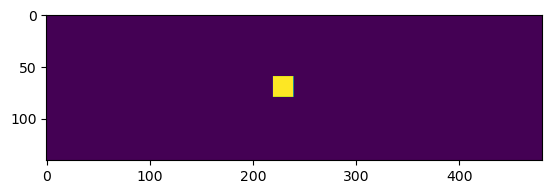

In [5]:
# run forward modeling to generate obs data
plt.imshow(vp_true.T)
solver.run(simu_type = 'forward', simu_tag = 'obs', data_format= 'su')

In [5]:
from workflow import FWI
fwi = FWI(solver, optimizer)
fwi.run()

Initial fcost: 6.115739899257689e-09 

failure 2
fcost : 3.4674337557006627e-09
optimize.fk : 6.115739899257689e-09
optimize.alpha : 1.0
optimize.q0 : -542992.3930728963
optimize.q : -508843.3281738483
m1 : 0.0
m2 : 0.9
cpt_ls is :  0
failure 1
fcost : 2.5053768701541287e-08
optimize.fk : 6.115739899257689e-09
optimize.alpha : 10.0
optimize.q0 : -542992.3930728963
m1 : 0.0
cpt_ls is :  1
fcost : 4.421634426592984e-09
optimize.f0 : 6.115739899257689e-09
optimize.fk : 6.115739899257689e-09
optimize.alpha : 5.5
optimize.q : 560397.4355120418
optimize.q0 : -542992.3930728963
m1 : 0.0
cpt_ls is :  2
failure 1
fcost : 8.345221946254269e-05
optimize.fk : 4.421634426592984e-09
optimize.alpha : 5.5
optimize.q0 : -9086674.46555023
m1 : 0.0
cpt_ls is :  0
failure 1
fcost : 6.316695713396139e-07
optimize.fk : 4.421634426592984e-09
optimize.alpha : 2.75
optimize.q0 : -9086674.46555023
m1 : 0.0
cpt_ls is :  1
failure 1
fcost : 2.2197708953821724e-07
optimize.fk : 4.421634426592984e-09
optimize.alpha

KeyboardInterrupt: 

In [ ]:
# fcost_all_src, fcost, grad = fwi.calculate_gradient_misfit(vp = vp_init, rho = rho_init)
# plt.imshow(grad.T, vmin = -120, vmax = 120)

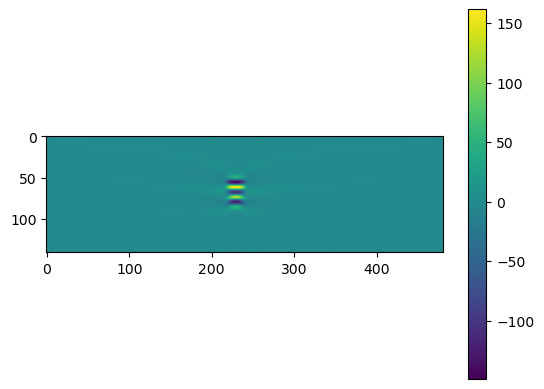

In [11]:
plt.imshow(solver.model.vp.T - vp_init.T)
plt.colorbar()

In [ ]:
# grad = np.zeros((nx, nz))
# for i in range(srcn):
#     grad += load_float(config.path + 'data/syn/src{}/vp_gradient.bin'.format(i+1)).reshape(nx, nz)
# grad = grad/grad.max()
# plt.imshow(grad.T, vmin = -0.6, vmax = 0.6)